In [15]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [16]:
# 1. Load environment variables
load_dotenv()
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DATABASE_URL)


In [17]:
# 2. SQL Queries to create stroke cohort and LOS target

# Drop if exists
drop_stroke_cohort = """DROP TABLE IF EXISTS stroke_cohort_los;"""

# Create stroke cohort with ICU stay duration
create_stroke_cohort = """
SELECT DISTINCT icu.subject_id, icu.hadm_id, icu.icustay_id,
       d.icd9_code,
       EXTRACT(EPOCH FROM (icu.outtime - icu.intime))/86400 AS los_days
INTO stroke_cohort_los
FROM mimiciii.diagnoses_icd d
JOIN mimiciii.icustays icu ON d.hadm_id = icu.hadm_id
WHERE d.icd9_code IN ('430', '431', '433', '434')
  AND icu.intime IS NOT NULL
  AND icu.outtime IS NOT NULL;
"""

# Basic demographics
create_demographics = """
SELECT sc.subject_id, p.gender, p.dob, a.ethnicity, a.admittime,
       ROUND(EXTRACT(YEAR FROM age(a.admittime, p.dob))) AS age
FROM stroke_cohort_los sc
JOIN mimiciii.patients p ON sc.subject_id = p.subject_id
JOIN mimiciii.admissions a ON sc.hadm_id = a.hadm_id;
"""

# Medication usage (antiplatelet/anticoagulant)
create_prescriptions = """
SELECT DISTINCT sc.subject_id, sc.hadm_id,
       CASE WHEN LOWER(p.drug) LIKE '%aspirin%' OR LOWER(p.drug) LIKE '%clopidogrel%' THEN 1 ELSE 0 END AS antiplatelet,
       CASE WHEN LOWER(p.drug) LIKE '%heparin%' OR LOWER(p.drug) LIKE '%warfarin%' OR LOWER(p.drug) LIKE '%enoxaparin%' THEN 1 ELSE 0 END AS anticoagulant
FROM stroke_cohort_los sc
LEFT JOIN mimiciii.prescriptions p ON sc.hadm_id = p.hadm_id;
"""

# Labs (coagulation, metabolic, cbc)
create_labevents = """
SELECT le.subject_id, le.hadm_id, le.itemid, le.charttime, le.valuenum
FROM mimiciii.labevents le
JOIN mimiciii.icustays icu ON le.hadm_id = icu.hadm_id
WHERE le.charttime BETWEEN icu.intime AND icu.intime + INTERVAL '24 hours'
  AND le.itemid IN (51237, 51275, 51265, 50983, 50971, 51222, 51300);
"""


In [18]:
# 3. Load Data
with engine.connect() as conn:
    conn.execute(text(drop_stroke_cohort))
    conn.execute(text(create_stroke_cohort))

    stroke_df = pd.read_sql("SELECT * FROM stroke_cohort_los;", conn)
    demo_df = pd.read_sql(text(create_demographics), conn)
    rx_df = pd.read_sql(text(create_prescriptions), conn)
    lab_df = pd.read_sql(text(create_labevents), conn)


In [19]:
# 4. Process Data

# Process labs
lab_mapping = {
    51237: 'inr',
    51275: 'aptt',
    51265: 'platelet_count',
    50983: 'sodium',
    50971: 'potassium',
    51222: 'hemoglobin',
    51300: 'wbc'
}

lab_df = lab_df[lab_df['itemid'].isin(lab_mapping.keys())]
lab_df = lab_df.sort_values(['subject_id', 'hadm_id', 'itemid', 'charttime'])
lab_df = lab_df.groupby(['subject_id', 'hadm_id', 'itemid']).first().reset_index()
lab_df['test_name'] = lab_df['itemid'].map(lab_mapping)
lab_pivot = lab_df.pivot_table(
    index=['subject_id', 'hadm_id'],
    columns='test_name',
    values='valuenum',
    aggfunc='first'
).reset_index()

# Process demographics
value_counts = demo_df['ethnicity'].value_counts()
rare_ethnicities = value_counts[value_counts < 20].index.tolist()
demo_df['ethnicity_processed'] = demo_df['ethnicity'].apply(lambda x: 'OTHER' if x in rare_ethnicities else x)
ethnicity_dummies = pd.get_dummies(demo_df['ethnicity_processed'], prefix='ethnicity')
demo_df = pd.concat([demo_df.drop(columns=['ethnicity', 'ethnicity_processed']), ethnicity_dummies], axis=1)

# Merge everything
final_df = stroke_df.merge(demo_df, on='subject_id', how='left')
final_df = final_df.merge(rx_df, on=['subject_id', 'hadm_id'], how='left')
final_df = final_df.merge(lab_pivot, on=['subject_id', 'hadm_id'], how='left')

# Ensure icd9_code is numeric
final_df['icd9_code'] = pd.to_numeric(final_df['icd9_code'], errors='coerce')

# Fill missing values
for col in ['platelet_count', 'aptt', 'inr', 'potassium', 'sodium', 'hemoglobin', 'wbc']:
    final_df[col] = final_df[col].fillna(final_df[col].median())
final_df[['antiplatelet', 'anticoagulant']] = final_df[['antiplatelet', 'anticoagulant']].fillna(0)
final_df.dropna(inplace=True)

# Convert gender to binary
final_df['gender'] = final_df['gender'].map({'M': 0, 'F': 1})

print("Final dataset shape:", final_df.shape)


Final dataset shape: (5171, 25)


In [20]:
# 5. Bring in ICU LOS
with engine.connect() as conn:
    los_df = pd.read_sql(text("""
        SELECT icustay_id, hadm_id, los
        FROM mimiciii.icustays
    """), conn)

# Merge LOS into the final dataset
final_df = final_df.merge(los_df[['hadm_id', 'los']], on='hadm_id', how='left')

# Drop rows where LOS is missing (safety measure)
final_df.dropna(subset=['los'], inplace=True)

print("Final dataset shape after adding LOS:", final_df.shape)
display(final_df.head())


Final dataset shape after adding LOS: (6923, 26)


,subject_id,hadm_id,icustay_id,icd9_code,los_days,gender,dob,admittime,age,ethnicity_ASIAN,...,antiplatelet,anticoagulant,aptt,hemoglobin,inr,platelet_count,potassium,sodium,wbc,los
0,9,150750,220597,431,5.323056,0,2108-01-26,2149-11-09 13:06:00,41.0,False,...,0,0,27.0,12.9,1.2,249.0,3.0,136.0,23.5,5.3231
1,67,155252,226216,431,0.214815,0,2084-06-05,2157-12-02 00:45:00,73.0,False,...,0,0,27.0,11.9,1.2,217.0,3.9,139.0,23.5,0.2148
2,81,175016,222874,431,1.513738,0,2106-12-20,2192-01-09 18:50:00,85.0,False,...,0,0,23.6,11.5,1.1,310.0,3.8,127.0,23.5,1.5137
3,103,130744,212246,431,3.023669,1,2084-04-14,2144-08-12 17:37:00,60.0,False,...,0,1,25.5,8.8,1.2,313.0,4.5,139.0,23.5,3.0237
4,103,130744,212246,431,3.023669,1,2084-04-14,2144-08-12 17:37:00,60.0,False,...,0,0,25.5,8.8,1.2,313.0,4.5,139.0,23.5,3.0237


In [21]:
# 6. Define Features (X) and Target (y)
ethnicity_cols = [col for col in final_df.columns if col.startswith('ethnicity_')]

X = final_df[['gender', 'age', 'icd9_code', 'antiplatelet', 'anticoagulant',
              'aptt', 'inr', 'platelet_count', 'potassium', 'sodium',
              'hemoglobin', 'wbc'] + ethnicity_cols]

y = final_df['los']  # Target is ICU Length of Stay


In [22]:
# 7. Train/Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (5538, 19)
Testing set shape: (1385, 19)



Linear Regression Results:
MAE: 4.79
RMSE: 6.76
R2: 0.06


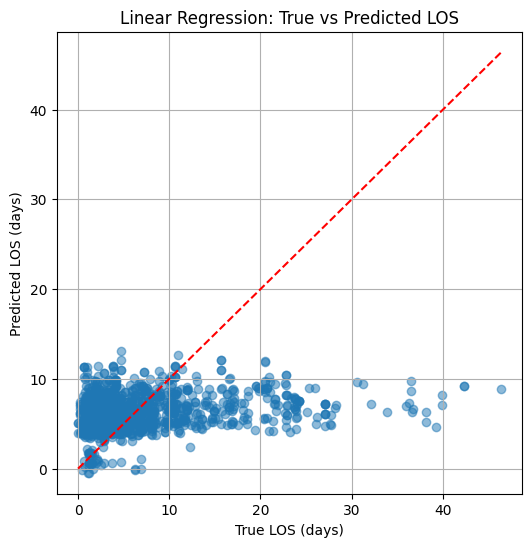


Random Forest Results:
MAE: 2.83
RMSE: 4.66
R2: 0.55


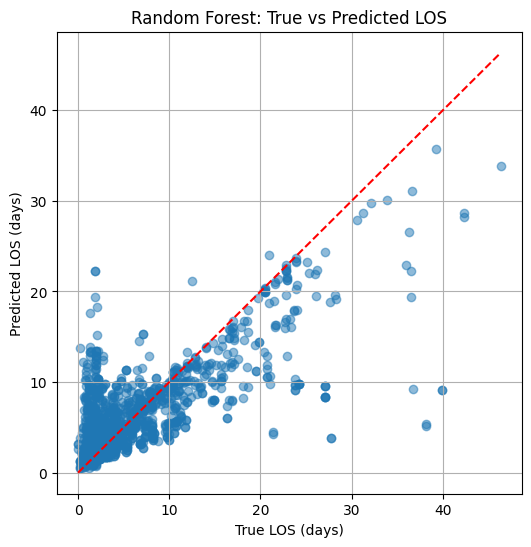

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 5538, number of used features: 18
[LightGBM] [Info] Start training from score 6.318886

LightGBM Results:
MAE: 3.50
RMSE: 5.32
R2: 0.42


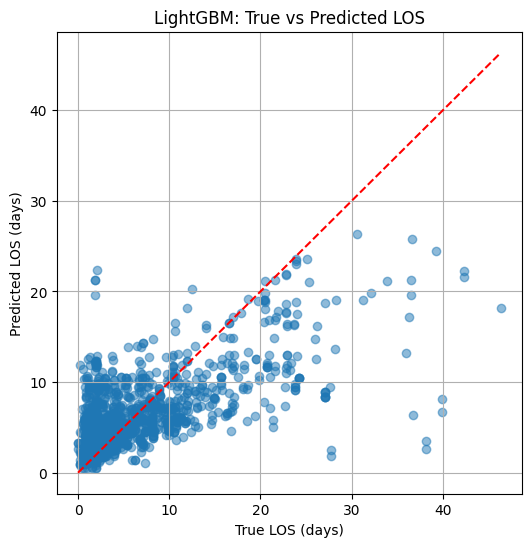

In [23]:
# 8. Build and Train Models

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)  # Correct way to compute RMSE
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    print(f"\n{name} Results:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

    # Plot predictions vs true values
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True LOS (days)')
    plt.ylabel('Predicted LOS (days)')
    plt.title(f'{name}: True vs Predicted LOS')
    plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
    plt.grid(True)
    plt.savefig(f"{name.replace(' ', '_').lower()}_los_predictions.png")
    plt.show()


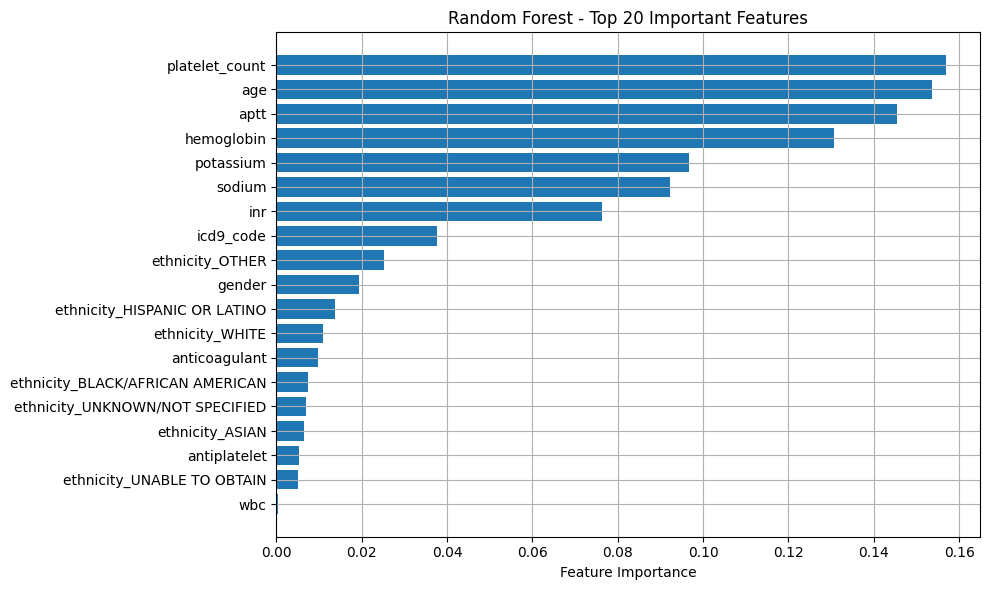

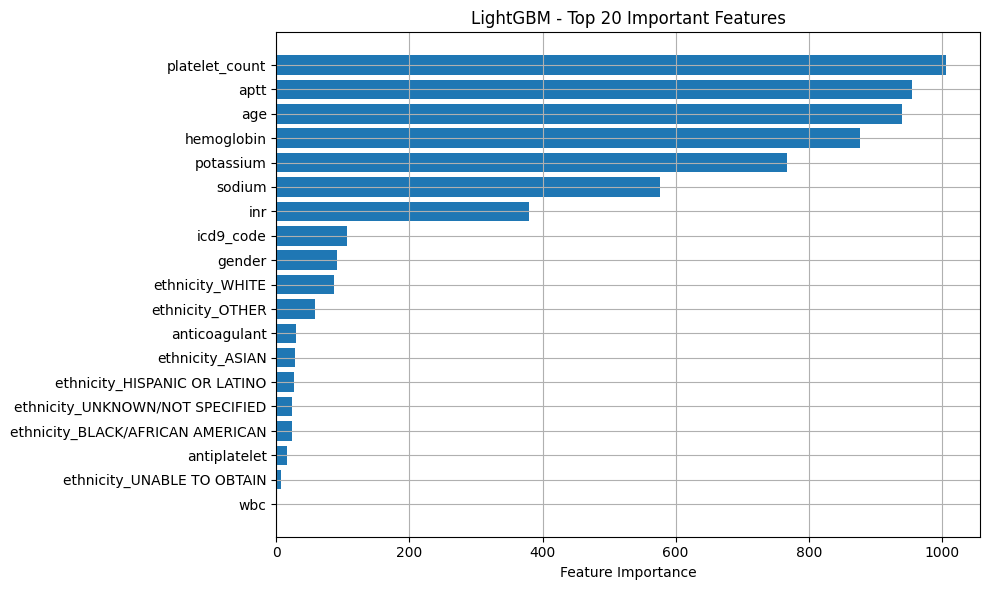

In [24]:
# 9. Feature Importance

def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]

        plt.figure(figsize=(10, 6))
        plt.barh(np.array(feature_names)[sorted_idx][:20][::-1], importance[sorted_idx][:20][::-1])
        plt.xlabel("Feature Importance")
        plt.title(f"{model_name} - Top 20 Important Features")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{model_name.replace(' ', '_').lower()}_feature_importance.png")
        plt.show()
    else:
        print(f"{model_name} does not support feature importance.")

# Plot feature importance for Random Forest and LightGBM
plot_feature_importance(models['Random Forest'], "Random Forest", X_train.columns)
plot_feature_importance(models['LightGBM'], "LightGBM", X_train.columns)


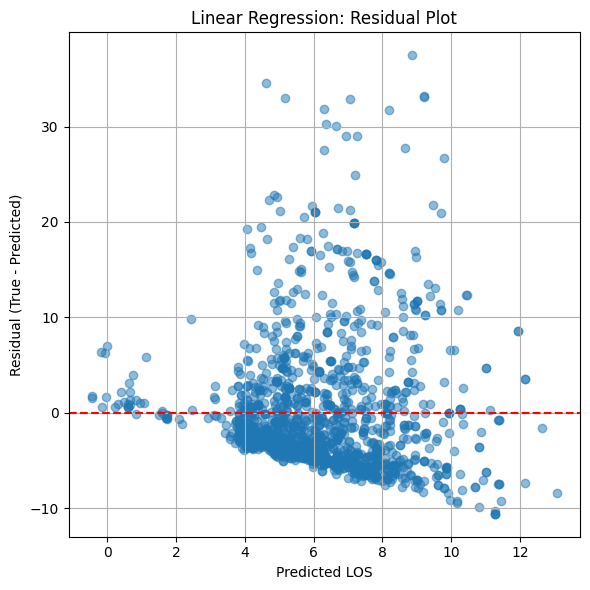

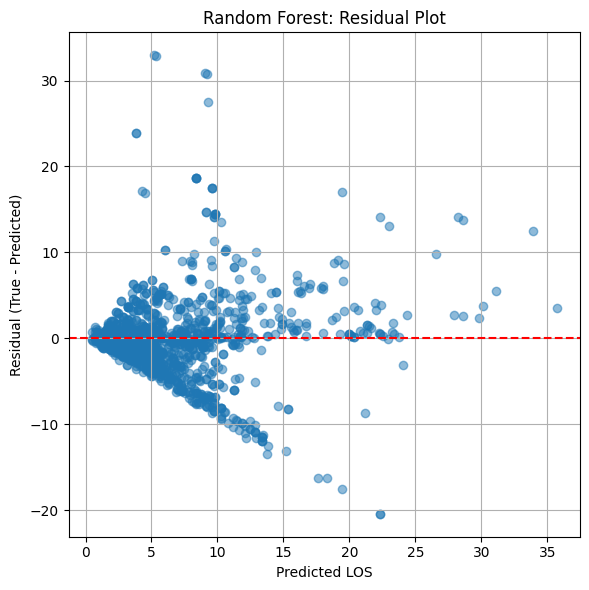

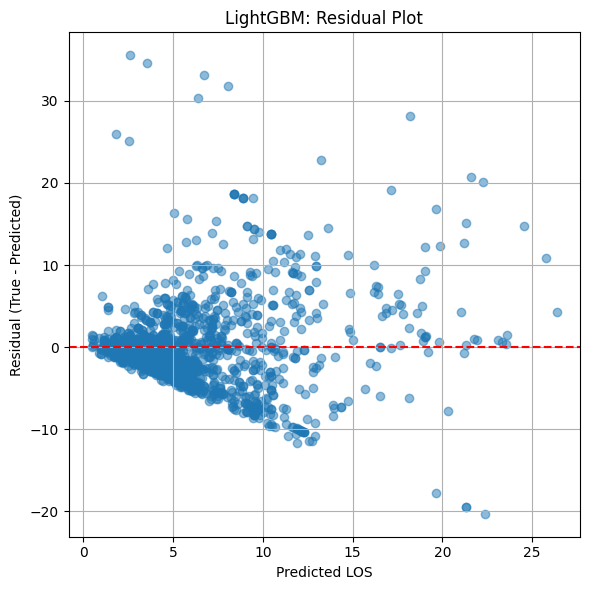

In [28]:
# 10. Residual Plots

for name, model in models.items():
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted LOS')
    plt.ylabel('Residual (True - Predicted)')
    plt.title(f'{name}: Residual Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name.replace(' ', '_').lower()}_residuals.png")
    plt.show()


In [26]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgbm

# 11. Hyperparameter Tuning

# Random Forest tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_params,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print("Best Random Forest Params:", rf_search.best_params_)

# LightGBM tuning
lgbm_params = {
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 5, 10]
}

lgbm_search = RandomizedSearchCV(
    LGBMRegressor(random_state=42),
    param_distributions=lgbm_params,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

lgbm_search.fit(X_train, y_train)
print("Best LightGBM Params:", lgbm_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Random Forest Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 5538, number of used features: 18
[LightGBM] [Info] Start training from score 6.318886
Best LightGBM Params: {'num_leaves': 31, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.05}


In [ ]:
# 12. Summary Table

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('RMSE')
display(results_df)



,MAE,RMSE,R2
Random Forest,2.829907,4.658972,0.552987
LightGBM,3.503025,5.320682,0.416992
Linear Regression,4.789076,6.760432,0.058785



Tuned Random Forest Final Results:
MAE: 2.82
RMSE: 4.66
R2: 0.55


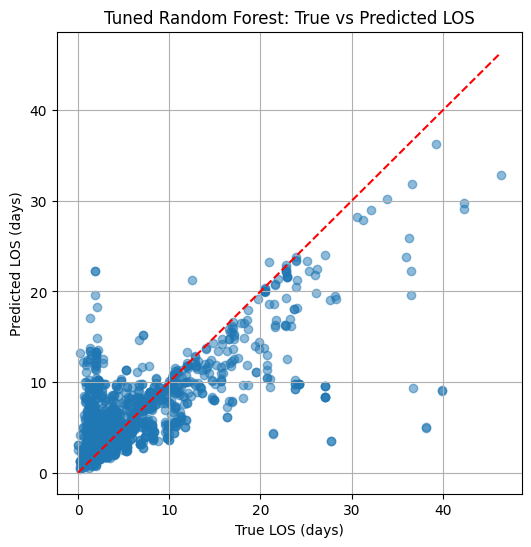

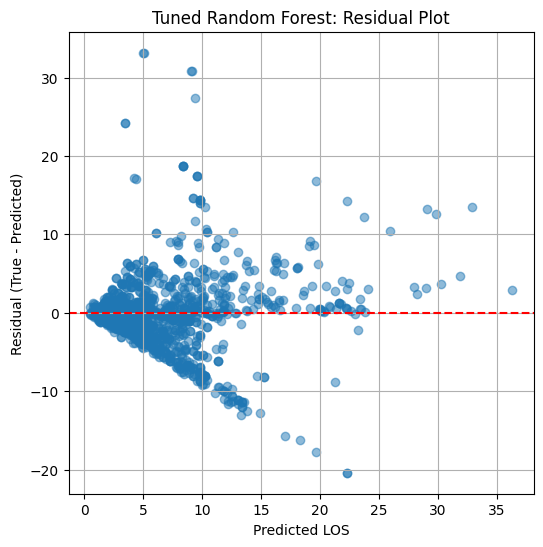

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 5538, number of used features: 18
[LightGBM] [Info] Start training from score 6.318886

Tuned LightGBM Final Results:
MAE: 3.50
RMSE: 5.32
R2: 0.42


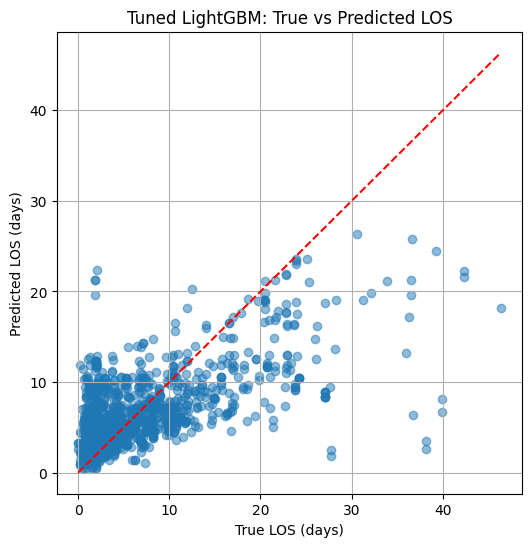

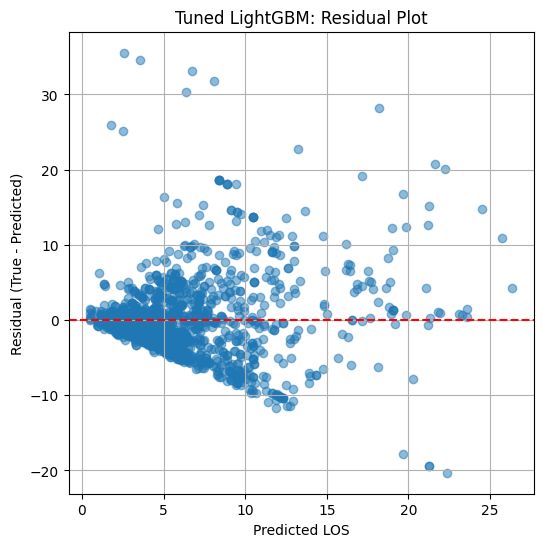

In [29]:
# 12. Retrain Tuned Models and Final Evaluation

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define models with best found parameters
tuned_models = {
    "Tuned Random Forest": RandomForestRegressor(
        n_estimators=300,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=None,
        random_state=42
    ),
    "Tuned LightGBM": LGBMRegressor(
        num_leaves=31,
        n_estimators=200,
        max_depth=-1,
        learning_rate=0.05,
        random_state=42
    )
}

tuned_results = {}

for name, model in tuned_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    tuned_results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    print(f"\n{name} Final Results:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

    # Plot true vs predicted
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
    plt.xlabel('True LOS (days)')
    plt.ylabel('Predicted LOS (days)')
    plt.title(f'{name}: True vs Predicted LOS')
    plt.grid(True)
    plt.savefig(f"{name.replace(' ', '_').lower()}_final_predictions.png")
    plt.show()

    # Plot residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(6,6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted LOS')
    plt.ylabel('Residual (True - Predicted)')
    plt.title(f'{name}: Residual Plot')
    plt.grid(True)
    plt.savefig(f"{name.replace(' ', '_').lower()}_final_residuals.png")
    plt.show()


In [30]:
# 13. Final Summary Table

import pandas as pd

# Combine all results
summary_results = {}

# Add original (untuned) results
for name, metrics in results.items():
    summary_results[name + " (Original)"] = metrics

# Add tuned results
for name, metrics in tuned_results.items():
    summary_results[name + " (Tuned)"] = metrics

# Create dataframe
summary_df = pd.DataFrame(summary_results).T  # Transpose for easier reading

# Clean up column names
summary_df.columns = ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'R2 Score']

# Sort by RMSE (lower is better)
summary_df = summary_df.sort_values('Root Mean Squared Error (RMSE)')

# Display nicely
print("\nFinal Model Comparison Table:")
display(summary_df.round(3))

# Optionally save to CSV
summary_df.to_csv("final_model_comparison.csv")



Final Model Comparison Table:


,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE),R2 Score
Tuned Random Forest (Tuned),2.824,4.658,0.553
Random Forest (Original),2.830,4.659,0.553
LightGBM (Original),3.503,5.321,0.417
Tuned LightGBM (Tuned),3.503,5.321,0.417
Linear Regression (Original),4.789,6.760,0.059
